In [17]:
import pandas as pd
df=pd.read_csv("/Users/pranav/Downloads/data.csv",encoding='unicode_escape')

In [18]:
print(df.describe())
print(df.columns)


            Quantity      UnitPrice     CustomerID
count  541909.000000  541909.000000  406829.000000
mean        9.552250       4.611114   15287.690570
std       218.081158      96.759853    1713.600303
min    -80995.000000  -11062.060000   12346.000000
25%         1.000000       1.250000   13953.000000
50%         3.000000       2.080000   15152.000000
75%        10.000000       4.130000   16791.000000
max     80995.000000   38970.000000   18287.000000
Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')


In [19]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


(541909, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029

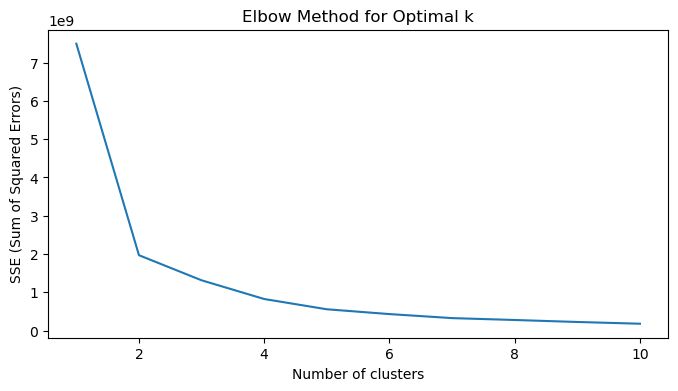

/var/folders/fy/4kwzbshx6671r7wl5z9y1v9c0000gn/T/ipykernel_24923/3693776538.py:90: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Cluster', y='Recency', data=segment_profile, ci=None)


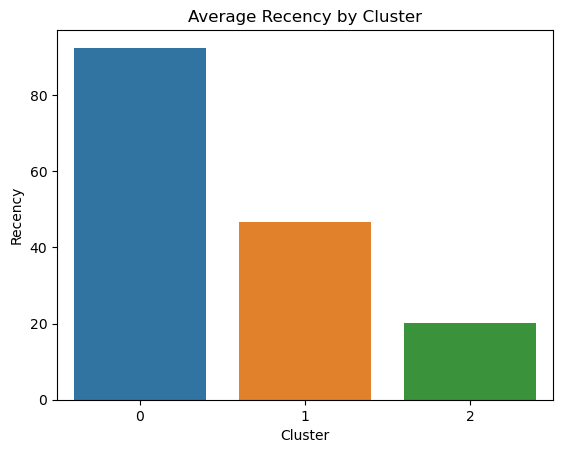

In [20]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans

# Load the dataset
df = pd.read_csv("/Users/pranav/Downloads/data.csv", encoding='unicode_escape').copy()

# Explore the dataset
print(df.shape)
print(df.info())
print(df.head())

# Handle missing values
df = df.dropna()

# Convert data types if needed
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# RFM Calculation
snapshot_date = max(df['InvoiceDate']) + pd.Timedelta(days=1)

# Calculate Recency, Frequency, and Monetary values
rfm_table = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'UnitPrice': 'sum'
}).reset_index()  # Reset index to avoid SettingWithCopyWarning

# Rename columns for clarity
rfm_table.rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'UnitPrice': 'Monetary'}, inplace=True)

# RFM Segmentation
# Define quartiles for Recency, Frequency, and Monetary
quantiles = rfm_table.quantile(q=[0.25, 0.5, 0.75])

# Function to assign RFM scores
def rfm_score(x, metric, quantiles):
    if x <= quantiles[metric][0.25]:
        return 1
    elif x <= quantiles[metric][0.50]:
        return 2
    elif x <= quantiles[metric][0.75]:
        return 3
    else:
        return 4

# Apply RFM scores to each customer
rfm_table['R'] = rfm_table['Recency'].apply(rfm_score, args=('Recency', quantiles))
rfm_table['F'] = rfm_table['Frequency'].apply(rfm_score, args=('Frequency', quantiles))
rfm_table['M'] = rfm_table['Monetary'].apply(rfm_score, args=('Monetary', quantiles))

# Combine RFM scores to create a single RFM score
rfm_table['RFM_Score'] = rfm_table['R'].astype(str) + rfm_table['F'].astype(str) + rfm_table['M'].astype(str)

# Customer Segmentation using K-Means clustering
X = rfm_table[['Recency', 'Frequency', 'Monetary']]

# Determine the optimal number of clusters using the Elbow method
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)  # Explicitly set n_init
    kmeans.fit(X)
    sse[k] = kmeans.inertia_

# Plot Elbow method to find optimal k
plt.figure(figsize=(8, 4))
sns.lineplot(x=list(sse.keys()), y=list(sse.values()))
plt.xlabel('Number of clusters')
plt.ylabel('SSE (Sum of Squared Errors)')
plt.title('Elbow Method for Optimal k')
plt.show()

# Based on the Elbow method, choose the optimal number of clusters
optimal_k = 3

# Apply K-Means clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)  # Explicitly set n_init
rfm_table['Cluster'] = kmeans.fit_predict(X)

# Segment Profiling
segment_profile = rfm_table.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).reset_index()

# Segment Profiling Visualization
sns.barplot(x='Cluster', y='Recency', data=segment_profile, ci=None)
plt.title('Average Recency by Cluster')
plt.show()



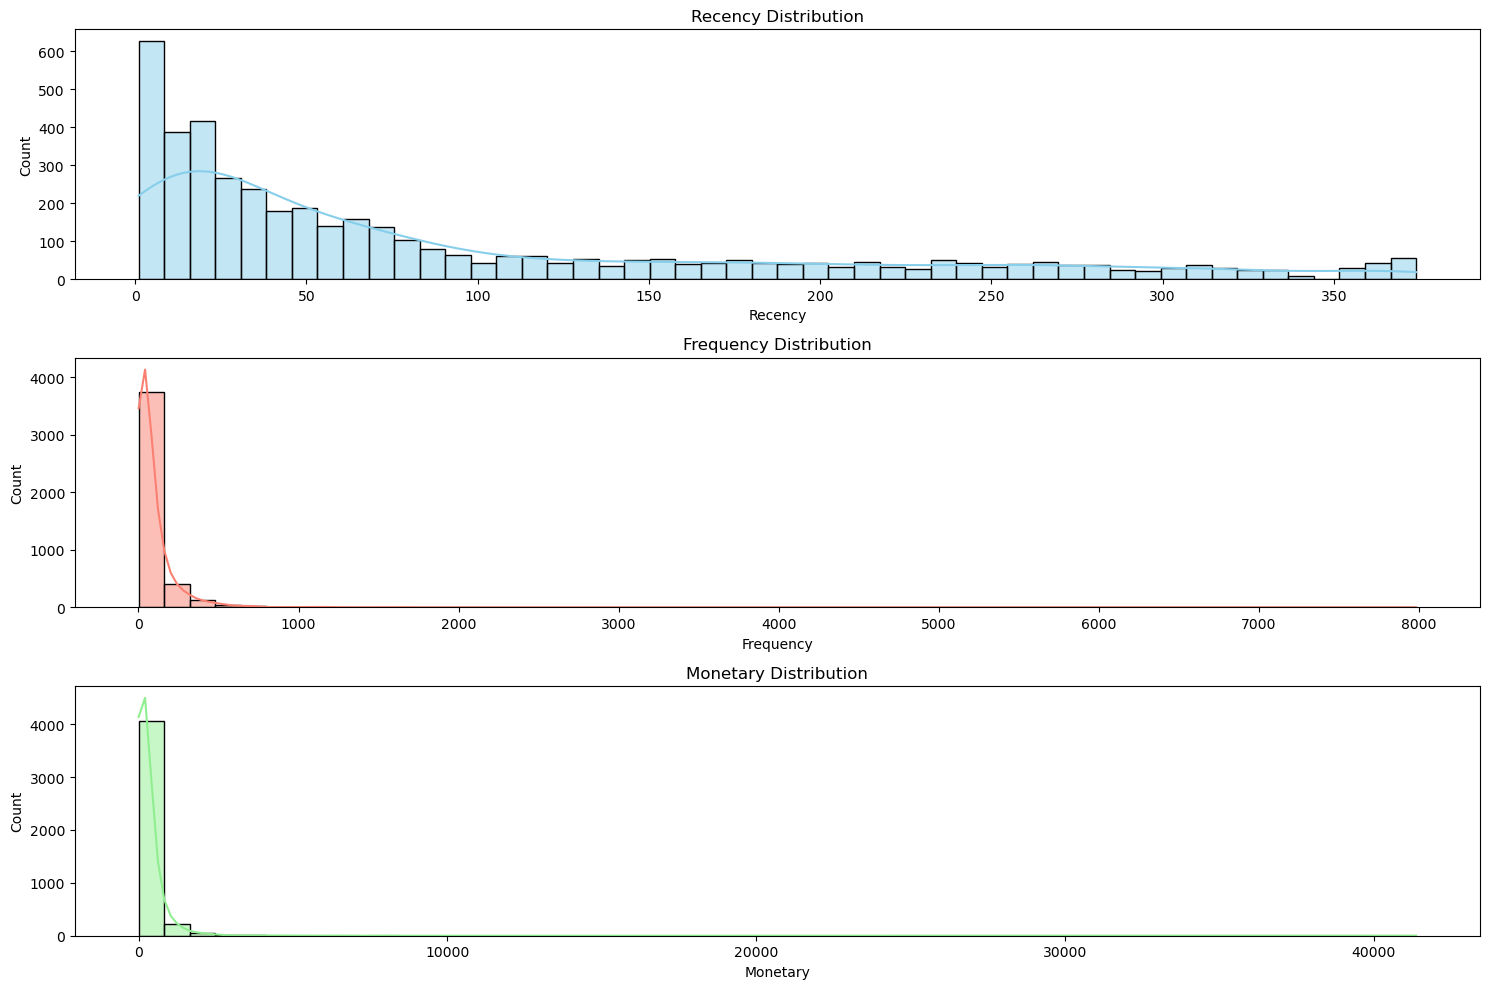

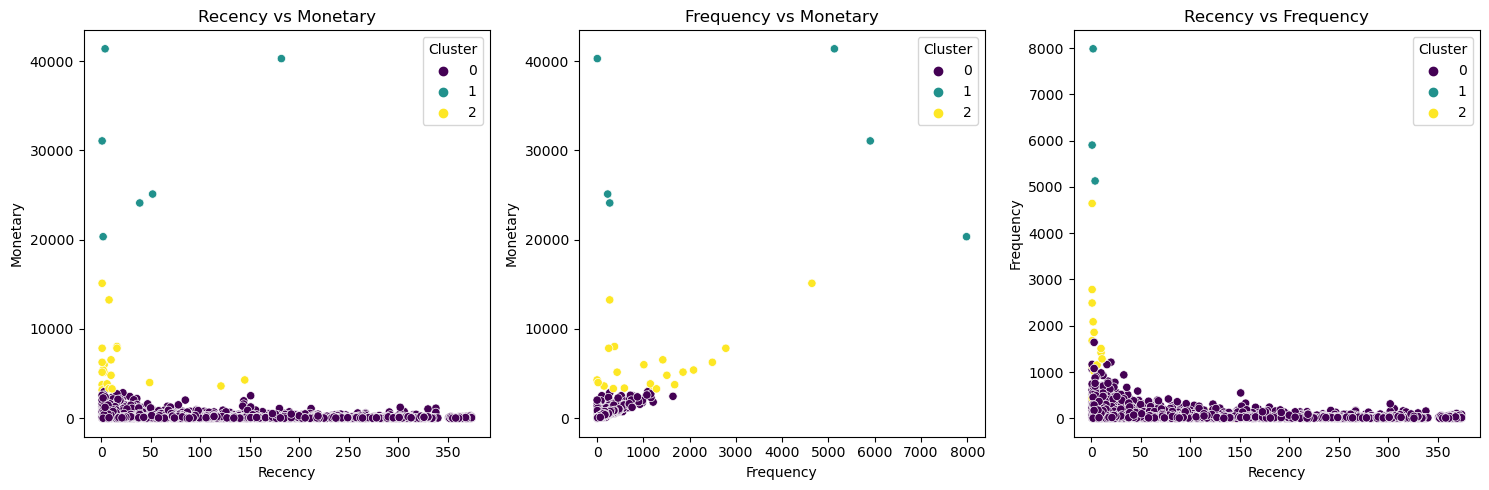

In [21]:
# Additional Visualizations
# Visualize RFM Distribution
plt.figure(figsize=(15, 10))

# Recency Distribution
plt.subplot(3, 1, 1)
sns.histplot(rfm_table['Recency'], bins=50, kde=True, color='skyblue')
plt.title('Recency Distribution')

# Frequency Distribution
plt.subplot(3, 1, 2)
sns.histplot(rfm_table['Frequency'], bins=50, kde=True, color='salmon')
plt.title('Frequency Distribution')

# Monetary Distribution
plt.subplot(3, 1, 3)
sns.histplot(rfm_table['Monetary'], bins=50, kde=True, color='lightgreen')
plt.title('Monetary Distribution')

plt.tight_layout()
plt.show()

# Visualize Clusters
plt.figure(figsize=(15, 5))

# Scatter plot for Recency vs Monetary with Cluster coloring
plt.subplot(1, 3, 1)
sns.scatterplot(x='Recency', y='Monetary', hue='Cluster', data=rfm_table, palette='viridis')
plt.title('Recency vs Monetary')

# Scatter plot for Frequency vs Monetary with Cluster coloring
plt.subplot(1, 3, 2)
sns.scatterplot(x='Frequency', y='Monetary', hue='Cluster', data=rfm_table, palette='viridis')
plt.title('Frequency vs Monetary')

# Scatter plot for Recency vs Frequency with Cluster coloring
plt.subplot(1, 3, 3)
sns.scatterplot(x='Recency', y='Frequency', hue='Cluster', data=rfm_table, palette='viridis')
plt.title('Recency vs Frequency')

plt.tight_layout()
plt.show()


In [22]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [23]:
top_countries = df['Country'].value_counts().nlargest(5)
print("Top 5 countries with the highest number of orders:")
print(top_countries)

Top 5 countries with the highest number of orders:
Country
United Kingdom    361878
Germany             9495
France              8491
EIRE                7485
Spain               2533
Name: count, dtype: int64


In [24]:
average_order_value_by_country = df.groupby('Country')['UnitPrice'].mean().sort_values(ascending=False)
print("\nAverage order value by country:")
print(average_order_value_by_country)


Average order value by country:
Country
Singapore               109.645808
Portugal                  8.736392
Cyprus                    6.302363
Canada                    6.030331
Norway                    6.012026
Finland                   5.448705
Lebanon                   5.387556
Malta                     5.244173
EIRE                      5.110699
France                    5.049021
Spain                     4.987544
Channel Islands           4.932124
Greece                    4.885548
Italy                     4.831121
European Community        4.820492
Bahrain                   4.644118
Brazil                    4.456250
RSA                       4.277586
Austria                   4.243192
Poland                    4.170880
Germany                   3.966930
Sweden                    3.910887
Israel                    3.650000
Belgium                   3.644335
Switzerland               3.499521
United Arab Emirates      3.380735
Denmark                   3.256941
United Kingdom

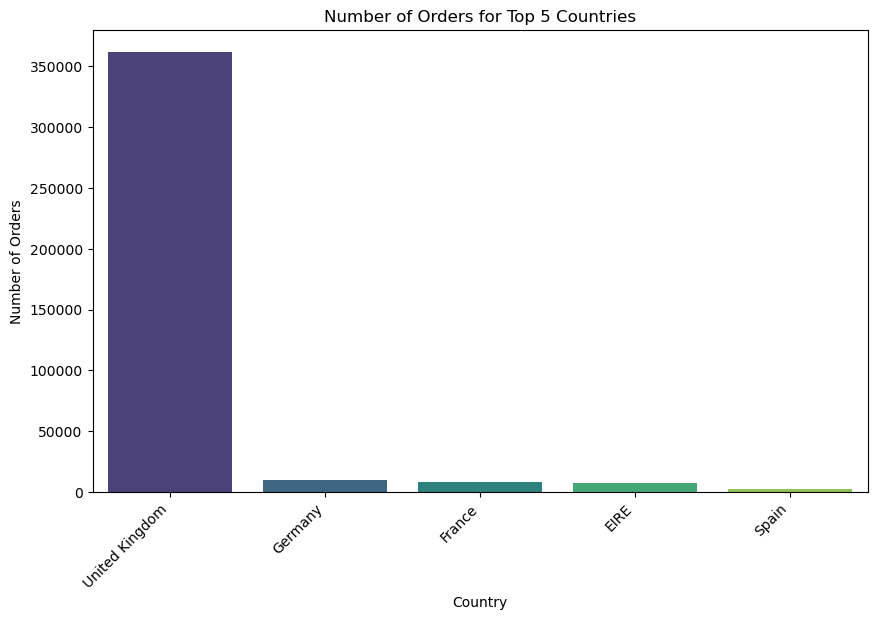

In [25]:
plt.figure(figsize=(10, 6))
sns.barplot(x=top_countries.index, y=top_countries.values, palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title('Number of Orders for Top 5 Countries')
plt.xlabel('Country')
plt.ylabel('Number of Orders')
plt.show()

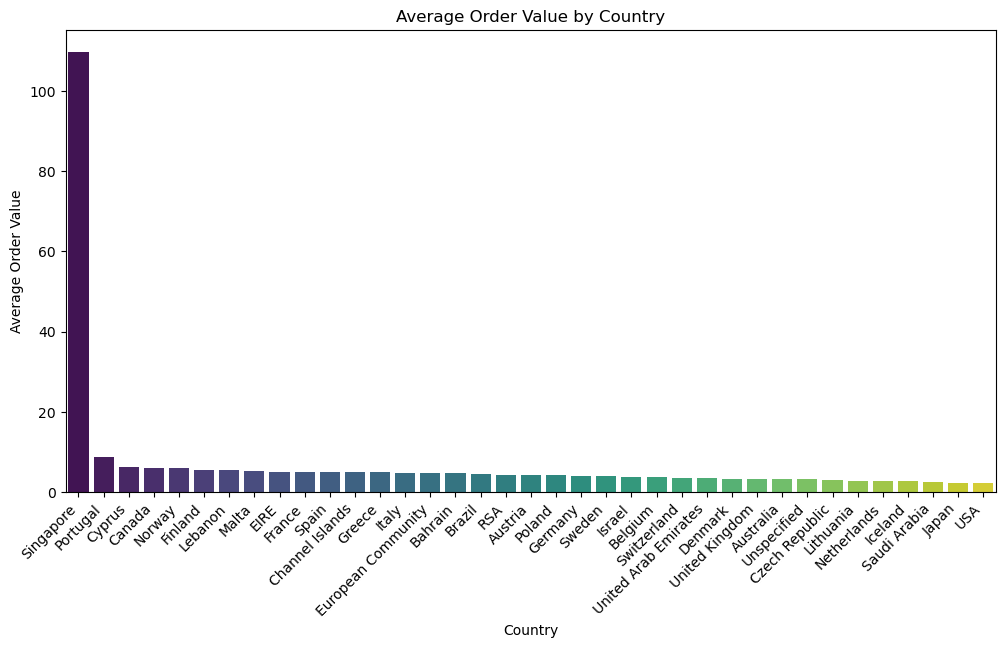

In [19]:
plt.figure(figsize=(12, 6))
sns.barplot(x=average_order_value_by_country.index, y=average_order_value_by_country.values, palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title('Average Order Value by Country')
plt.xlabel('Country')
plt.ylabel('Average Order Value')
plt.show()

In [26]:
# Calculate the average order value for each country
average_order_value_by_country = df.groupby('Country')['UnitPrice'].mean()

# Display the result
print("Average order value by country:")
print(average_order_value_by_country)

# Check correlation between country and average order value
correlation = df.groupby('Country')['UnitPrice'].mean().corr(df.groupby('Country')['UnitPrice'].count())

# Display correlation coefficient
print("Correlation between country and average order value:", correlation)


Average order value by country:
Country
Australia                 3.220612
Austria                   4.243192
Bahrain                   4.644118
Belgium                   3.644335
Brazil                    4.456250
Canada                    6.030331
Channel Islands           4.932124
Cyprus                    6.302363
Czech Republic            2.938333
Denmark                   3.256941
EIRE                      5.110699
European Community        4.820492
Finland                   5.448705
France                    5.049021
Germany                   3.966930
Greece                    4.885548
Iceland                   2.644011
Israel                    3.650000
Italy                     4.831121
Japan                     2.276145
Lebanon                   5.387556
Lithuania                 2.841143
Malta                     5.244173
Netherlands               2.738317
Norway                    6.012026
Poland                    4.170880
Portugal                  8.736392
RSA            

In [5]:
# Infer payment methods based on 'InvoiceNo'
df['PaymentMethod'] = df['InvoiceNo'].apply(lambda x: 'Credit Card' if x.startswith('C') else 'Other')

# Check unique values in the inferred 'PaymentMethod' column
payment_methods = df['PaymentMethod'].unique()
print("Inferred Payment Methods:", payment_methods)


Inferred Payment Methods: ['Other' 'Credit Card']


In [6]:
# Analyze the frequency of inferred payment methods
payment_method_counts = df['PaymentMethod'].value_counts()
print("Payment method frequencies:")
print(payment_method_counts)

Payment method frequencies:
PaymentMethod
Other          532621
Credit Card      9288
Name: count, dtype: int64


In [10]:
# Assuming you have loaded your DataFrame df

# Check unique values in the 'PaymentMethod' column
unique_payment_methods = df['PaymentMethod'].unique()
print("All Unique Payment Methods:", unique_payment_methods)


All Unique Payment Methods: ['Other' 'Credit Card']


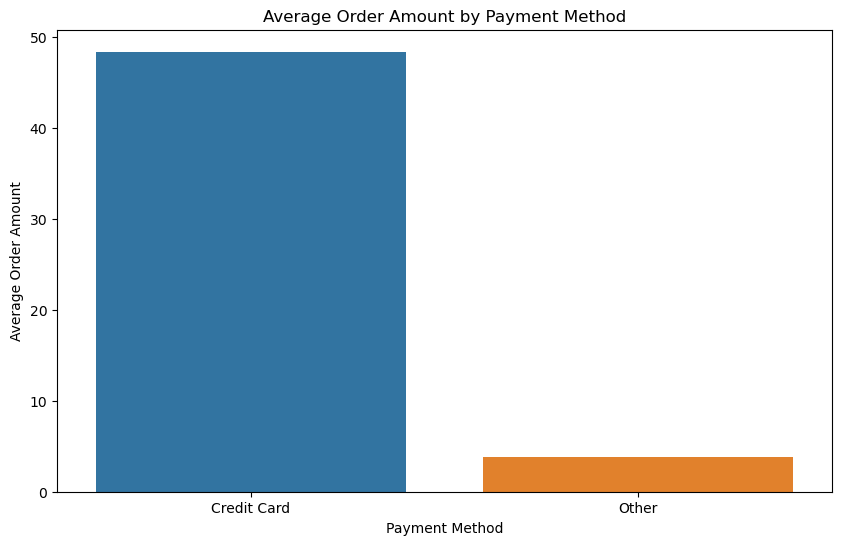

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by inferred payment method and calculate average order amount
average_order_amount_by_method = df.groupby('PaymentMethod')['UnitPrice'].mean()

# Visualize the relationship (for example, using a bar plot)
plt.figure(figsize=(10, 6))
sns.barplot(x=average_order_amount_by_method.index, y=average_order_amount_by_method.values)
plt.xlabel('Payment Method')
plt.ylabel('Average Order Amount')
plt.title('Average Order Amount by Payment Method')
plt.show()

In [12]:
# Group by payment method and calculate summary statistics for order amount
order_amount_summary = df.groupby('PaymentMethod')['UnitPrice'].describe()
print("Summary Statistics for Order Amount by Payment Method:")
print(order_amount_summary)


Summary Statistics for Order Amount by Payment Method:
                  count       mean         std       min   25%   50%   75%  \
PaymentMethod                                                                
Credit Card      9288.0  48.393661  666.600430      0.01  1.45  2.95  5.95   
Other          532621.0   3.847621   41.758023 -11062.06  1.25  2.08  4.13   

                    max  
PaymentMethod            
Credit Card    38970.00  
Other          13541.33  


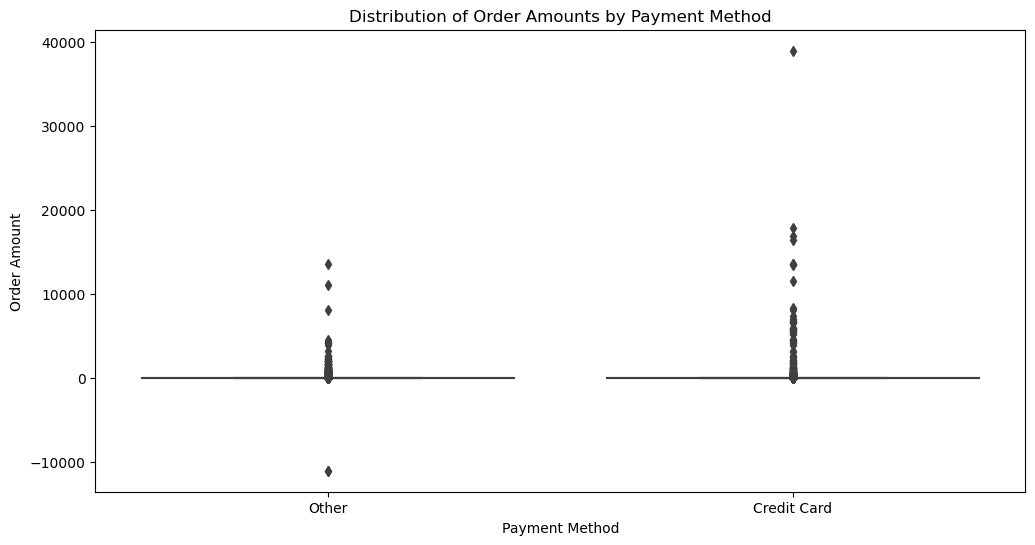

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize the distribution of order amounts for each payment method
plt.figure(figsize=(12, 6))
sns.boxplot(x='PaymentMethod', y='UnitPrice', data=df)
plt.xlabel('Payment Method')
plt.ylabel('Order Amount')
plt.title('Distribution of Order Amounts by Payment Method')
plt.show()
